In [24]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from time import gmtime, strftime
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import json
features = [
  'delivery_type', 'total_size', 'distance', 
  'delivery_dt', 'lat', 'long', 'task_around',

  'pickup_effective_dt', 'city', 'total_task', 'cost'
]
stad_cols = [
  'total_size', 'distance',
  'task_around', 'cost'
]
stad_cols_2 = [
  'lat', 'long',
]
stad_dates = [
  'delivery_dt', 'pickup_effective_dt'
]
#'pickup_effective_dt',
target = 'delivery_effective'
RANDOM = 2408
RESULTS = './results.csv'

In [11]:
class display(object):
  """Display HTML representation of multiple objects"""
  template = """<div style="float: left; padding: 10px;">
  <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
  </div>"""
  def __init__(self, *args):
    self.args = args

  def _repr_html_(self):
    return '\n'.join(self.template.format(a, eval(a)._repr_html_()) for a in self.args)

  def __repr__(self):
    return '\n\n'.join(a + '\n' + repr(eval(a)) for a in self.args)

def save_params(scalers, metrics):
  metrics_values = []
  for value in metrics.values():
    metrics_values.append(str(value))
  metada = []
  for key, value in scalers.items():
    metada.append({ key: value })
  with open(RESULTS, 'a') as f:
    f.write(f'{",".join(metrics_values)},{metada}\n')

def evaluate(y_test, y_pred, dataframe, threshold=1, save=False):
  pred_bool = np.where(dataframe['pred'] > dataframe['delivery_effective'], True, False)
  test_bool = np.where(dataframe['delivery_effective'] > dataframe['delivery_dt'], True, False)
  f1_pres = f1_score(test_bool, pred_bool)

  delta_pred_bool = (dataframe['pred'] - dataframe['delivery_effective']).dt.total_seconds() / 3600
  delta_pred_bool = np.where(delta_pred_bool > threshold, True, False)
  delta_test_bool = (dataframe['delivery_effective'] - dataframe['delivery_dt']).dt.total_seconds() / 3600
  delta_test_bool = np.where(delta_test_bool > threshold, True, False)

  f1_delta = f1_score(delta_pred_bool, delta_test_bool)  
  mae = mean_absolute_error(y_test, y_pred)
  mape = mean_absolute_percentage_error(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred, squared=False)
  r2 = r2_score(y_test, y_pred)

  if save:
    save_params({
      'threshold'  : threshold,
      'features'    : features,
      'stad_cols'   : scaler.get_params(deep=True),
      'stad_cols_2' : scaler_2.get_params(deep=True),
      'stad_dates'  : scaler_3.get_params(deep=True)
    },{
      'MAE' : mae,
      'MAPE': mape,
      'RMSE': rmse,
      'R2'  : r2,
      'f1_pres' : f1_pres,
      'f1_delta'  : f1_delta
    })
  print(
    '{0:10s}: {1}\n{2:10s}: {3}\n{4:10s}: {5}\n{6:10s}: {7}\n{8:10s}: {9}\n{10:10s}: {11}'.format(
    'MAE', mae, 'MAPE', mape, 'RMSE', rmse, 'r2', r2, 'f1 (press)', f1_pres, f'f1 (D {threshold})', f1_delta
  ))

In [25]:
df = pd.read_pickle("../data/shippify_icd_task_new.pkl", compression='gzip')
df.delivery_type = df.delivery_type.astype('category').cat.codes
df.total_size = df.total_size.astype('category').cat.codes

df.delivery_dt = df.delivery_dt.view('i8') / 1e9
df.pickup_effective_dt = df.pickup_effective_dt.view('i8') / 1e9
df.delivery_effective = df.delivery_effective.view('i8') / 1e9

In [26]:
scaler = MinMaxScaler(feature_range=(0, 10))
df[stad_cols] = scaler.fit_transform(df[stad_cols])

scaler_2 = MinMaxScaler(feature_range=(0, 10))
df[stad_cols_2] = scaler_2.fit_transform(df[stad_cols_2])

scaler_3 = MinMaxScaler(feature_range=(0, 100))
df[stad_dates] = scaler_3.fit_transform(df[stad_dates])
save_df = False
if save_df:
  df.to_csv('../data/shippify_vertex_std.csv', index=False)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.25, random_state=2408)

model = LinearRegression()
reg = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [28]:
threshold = 1
# Restore scale and type columns
X_test['pred'] = y_pred * 1e9 #scaler_target.inverse_transform(np.array(y_pred).reshape(-1,1))
X_test['delivery_effective'] = y_test * 1e9 #scaler_target.inverse_transform(np.array(y_test).reshape(-1,1))
X_test[stad_dates] = scaler_3.inverse_transform(X_test[stad_dates]) * 1e9
X_test.delivery_dt = X_test.delivery_dt.astype('datetime64[ns]')
X_test.delivery_effective = X_test.delivery_effective.astype('datetime64[ns]')
X_test.pred = X_test.pred.astype('datetime64[ns]')
# Calculate delta
X_test['delta'] = (X_test['delivery_effective'] - X_test['pred']).dt.total_seconds() / 3600

evaluate(y_test, y_pred, X_test, threshold, False)

MAE       : 19262.093211248033
MAPE      : 1.2077533436093928e-05
RMSE      : 126869.22192862631
r2        : 0.9969692376630388
f1 (press): 0.5718330713979557
f1 (D 1)  : 0.40957163031539306


In [106]:
delta_times = (X_test['delivery_effective'] - X_test['delivery_dt']).dt.total_seconds() / 3600
delta_times = np.where(delta_times >  threshold, True, False)
pd.DataFrame(delta_times).value_counts()

True     31853
False    24854
dtype: int64

In [107]:
#print(X_test[ X_test['delta'] > 20 ].describe())
X_test[ X_test['delta'] > 24 ]

,delivery_type,total_size,distance,delivery_dt,lat,long,task_around,pickup_effective_dt,city,total_task,cost,company_id,company_type,pred,delivery_effective,delta
97487,1,2.5,0.052777,2020-08-12 13:30:45,8.340606,0.241332,3.869969,1.597254e+18,3,226828,0.428571,982,1,2020-08-12 23:10:16.531588864,2020-08-14 02:29:38,27.322630
154803,1,10.0,0.064637,2020-07-24 20:08:29,7.669014,0.152544,0.072239,1.595600e+18,3,226828,0.427103,4418,1,2020-07-24 19:31:37.007980288,2020-07-27 16:42:41,69.184442
99428,1,2.5,0.092804,2020-06-15 18:30:00,8.854095,0.306697,1.661507,1.592256e+18,3,226828,0.428571,982,1,2020-06-16 02:41:18.546993408,2020-06-18 01:46:05,47.079570
219498,1,2.5,0.021644,2020-07-28 14:00:00,8.374022,0.180635,1.104231,1.595891e+18,3,226828,0.000000,4389,2,2020-07-28 00:22:22.972771840,2020-07-29 17:05:21,40.716119
203928,1,2.5,0.120971,2020-07-21 16:00:00,7.305906,0.242702,0.464396,1.595356e+18,3,226828,0.571429,4656,1,2020-07-22 04:00:47.105165312,2020-07-23 22:41:16,42.674693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212218,1,10.0,0.082130,2020-07-17 16:30:00,7.708852,0.247210,0.701754,1.595005e+18,3,226828,0.662857,1985,1,2020-07-17 20:16:33.774245376,2020-07-21 16:43:31,92.449229
147657,1,2.5,0.071160,2020-06-09 13:30:01,8.687656,0.266205,2.982456,1.591726e+18,3,226828,0.428571,982,1,2020-06-09 23:31:14.753594368,2020-06-10 23:36:08,24.081457
153584,1,2.5,0.116524,2020-06-05 16:00:00,7.428021,0.243826,0.206398,1.591380e+18,3,226828,0.571429,4656,1,2020-06-06 03:35:25.274785536,2020-06-08 21:11:18,65.597979
52646,1,2.5,0.130459,2020-07-20 16:00:00,7.258983,0.262582,0.154799,1.595282e+18,3,226828,0.571429,4656,1,2020-07-21 07:49:20.127324928,2020-07-22 23:46:41,39.955798


In [108]:
X_test[ X_test['delta'] < 24 ]

,delivery_type,total_size,distance,delivery_dt,lat,long,task_around,pickup_effective_dt,city,total_task,cost,company_id,company_type,pred,delivery_effective,delta
208501,1,10.0,0.091914,2020-06-08 20:00:23,8.924799,0.285447,0.804954,1.591646e+18,3,226828,0.884380,162,1,2020-06-08 20:42:36.651185152,2020-06-08 22:16:36,1.566486
134497,0,2.5,0.000000,2020-08-29 00:11:14,9.035980,0.179106,0.061920,1.598640e+18,3,226828,0.891429,3830,1,2020-08-28 20:43:29.336137984,2020-08-28 21:47:49,1.072129
167731,1,2.5,0.029353,2020-07-20 21:03:53,8.684444,0.250028,2.394221,1.595272e+18,3,226828,0.313811,753,1,2020-07-20 23:50:22.866489600,2020-07-20 19:45:01,4.089407
80528,1,2.5,0.061079,2020-06-18 13:30:36,8.527639,0.245521,4.798762,1.592484e+18,3,226828,0.428571,982,1,2020-06-18 17:52:27.184206848,2020-06-18 16:26:09,1.438385
114849,1,2.5,0.052480,2020-07-18 14:00:00,8.317463,0.245840,2.683179,1.595080e+18,3,226828,0.428571,982,1,2020-07-18 19:03:31.566238976,2020-07-18 16:12:34,2.849324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75697,1,2.5,0.047143,2020-06-08 14:00:00,7.962079,0.248898,0.970072,1.591624e+18,3,226828,0.428571,3747,1,2020-06-08 21:13:14.625890560,2020-06-08 19:39:54,1.555729
171502,1,10.0,0.039731,2020-08-12 16:00:00,8.081619,0.137650,0.309598,1.597245e+18,3,226828,0.386286,4418,1,2020-08-12 20:05:35.556036352,2020-08-12 17:42:58,2.377099
217302,0,2.5,0.021941,2020-07-31 20:06:54,8.631097,0.265401,2.270382,1.596219e+18,3,226828,0.640000,3295,1,2020-07-31 20:42:24.895467264,2020-07-31 19:40:09,1.037749
240371,0,2.5,0.018383,2020-07-30 16:14:47,8.519917,0.160994,0.743034,1.596124e+18,3,226828,0.388571,4707,1,2020-07-30 20:06:54.459291904,2020-07-30 16:34:59,3.532072


<AxesSubplot:xlabel='delta', ylabel='Density'>

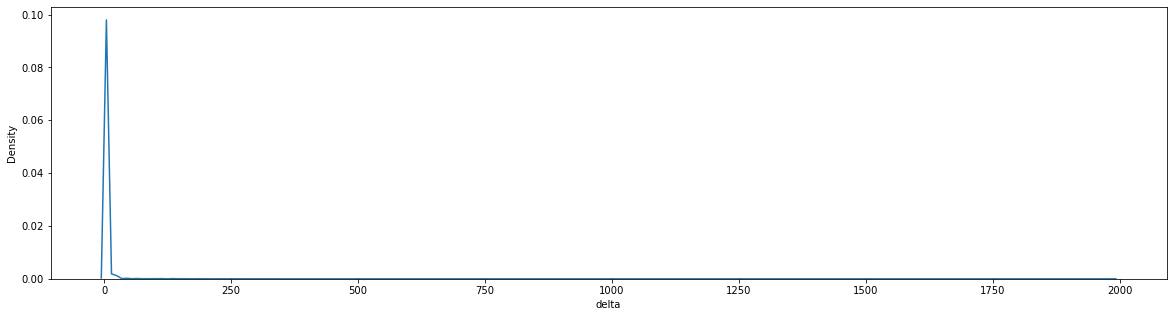

In [109]:
%matplotlib inline
plt.figure(figsize=(20,5))
sns.kdeplot(data=X_test['delta'])